In [1]:
import os
import sys
from typing import Union, Any, Optional, Callable, Tuple

ROOT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
if ROOT_DIR not in sys.path: sys.path.append(ROOT_DIR)

import numpy as np
import pandas as pd
import proplot as plot
import eagerpy as ep
import torch

from DeepSparseCoding.tf1x.utils.logger import Logger as tfLogger
import DeepSparseCoding.tf1x.analysis.analysis_picker as ap
from DeepSparseCoding.tf1x.data.dataset import Dataset
import DeepSparseCoding.tf1x.utils.data_processing as tfdp

from DeepSparseCoding.utils.file_utils import Logger
import DeepSparseCoding.utils.dataset_utils as dataset_utils
import DeepSparseCoding.utils.loaders as loaders
import DeepSparseCoding.utils.plot_functions as pf

from foolbox import PyTorchModel, accuracy
from foolbox.attacks.projected_gradient_descent import LinfProjectedGradientDescentAttack
from foolbox.types import Bounds
from foolbox.models.base import Model
from foolbox.attacks.base import T
from foolbox.criteria import Misclassification
from foolbox.attacks.base import raise_if_kwargs
from foolbox.attacks.base import get_criterion

rand_state = np.random.RandomState(123)

In [2]:
class params(object):
  def __init__(self):
    self.device = "/gpu:0"
    #Which dataset to run analysis on, options are "train", "val", or "test"
    self.analysis_dataset = "test"
    #Output directory file
    self.save_info = "analysis_" + self.analysis_dataset
    # If false, append to log file
    self.overwrite_analysis_log = False
    # Load in training run stats from log file
    self.do_run_analysis = False
    # Evaluate model variables (specified in analysis class) on images
    self.do_evals = False
    # Dictionary fitting
    self.do_basis_analysis = False
    # LCA Inference analysis
    self.do_inference = False #TODO: Does not work for lca_subspace
    # Activity triggered averages
    self.do_atas = False #TODO: this can produce outputs that are too big for npz; need to batch?
    # Recon adversarial image analysis
    self.do_recon_adversaries = False # TODO: broken for rica
    #Classification adversarial image analysis
    self.do_class_adversaries = True
    # Find optimal stimulus using gradient methods
    self.do_neuron_visualization = False # adversaries must be False
    # Patchwise image recon
    self.do_full_recon = False
    # Orientation and Cross-Orientation analysis
    self.do_orientation_analysis = False # TODO: broken for ae_deep
    # Reconstructions from individual groups for subspace Sparse Coding
    self.do_group_recons = False
    # How many images to use for analysis, patches are generated from these
    #self.num_analysis_images = 150#1000
    #self.whiten_batch_size = 10 # for VH dataset
    # How many input patches to create - only used if model calls for patching
    #self.num_patches = 1e4
    # How many images to use in the ATA analysis
    # NOTE: No warning is given if this is greater than the number of available images
    #self.num_ata_images = 5e2
    # How many noise images to compute noise ATAs
    #self.num_noise_images = 1e3
    # How many random images to average over for inference statistics
    #self.num_inference_images = 5
    # Number of images used for LCA_PCA cov matrix (should not be greater than num_patches)
    #self.num_LCA_PCA_cov_images = int(1e5)
    # Edge size of full (square) image (for full_recon)
    #self.image_edge_size = 128
    # Fourier analysis padding for weight fitting
    #self.ft_padding = 128
    # How many inference steps to perform (None uses model params)
    #self.num_inference_steps = None
    # Which dataset images to use for inference (None uses random)
    #self.inference_img_indices = None
    #Adversarial params
    self.adversarial_attack_method = "kurakin_untargeted"
    self.adversarial_step_size = 0.005 # learning rate for optimizer
    self.adversarial_num_steps = 500 # Number of iterations adversarial attacks
    self.adversarial_max_change = 1.0 # maximum size of adversarial perturation
    self.carlini_change_variable = False
    self.adv_optimizer = "sgd"
    #self.adversarial_target_method = "random" # Not used if attack_method is untargeted#TODO support specified
    self.adversarial_clip = True
    self.adversarial_clip_range = [0.0, 1.0] # Maximum range of image values
    #self.carlini_recon_mult = 0.1#list(np.arange(.5, 1, .1))
    self.adversarial_save_int = 1 # Interval at which to save adv examples to the npz file
    self.eval_batch_size = 50 # batch size for computing adv examples
    self.adversarial_input_id = np.arange(self.eval_batch_size, dtype=np.int32) # Which adv images to use; None to use all
    #Parameter for "specified" target_method
    #Only for class attack
    #Need to be a list or numpy array of size [adv_batch_size]
    self.adversarial_target_labels = None
    # Rescale inputs to match dataset scales used during training
    #self.input_scale = 1.0 # TODO: Get input_scale from log file
    # Which neurons to run tuning experiments on (None to do all)
    #self.neuron_indices = None
    # Contrasts for orientation experiments
    #self.contrasts = [0.1, 0.2, 0.3, 0.4, 0.5]
    # Phases for orientation experiments
    #self.phases = np.linspace(-np.pi, np.pi, 8)
    # Orientations for orientation experiments
    #self.orientations = np.linspace(0.0, np.pi, 16)
    # Optimal stimulus calculation
    #self.neuron_vis_num_steps = int(4e5)
    #self.neuron_vis_step_size = 2e-4
    #self.neuron_vis_save_int = 1000
    #self.neuron_vis_stim_save_int = int(1e5)
    #self.neuron_vis_clip = False
    #self.neuron_vis_clip_range = [0.0, 1.0]
    #self.neuron_vis_method = "erhan"
    #self.neuron_vis_norm_magnitude = None
    #self.neuron_vis_l2_regularize_coeff = 0.001
    #self.neuron_vis_variation_coeff = 0.005
    #self.neuron_vis_optimizer = "sgd"
    #self.neuron_vis_target_layer = None
    #self.neuron_vis_targets = np.random.choice(range(10), 5, replace=False)
    #self.neuron_vis_target_neuron_idx = self.neuron_vis_targets[0] # TODO: Clean this up...
    #self.neuron_vis_selection_vector = np.zeros(10) # TODO: avoid hard-coding num neurons
    #self.neuron_vis_selection_vector[self.neuron_vis_target_neuron_idx] = 1

In [3]:
def create_mnist_dsc(log_file, cp_file):
    logger = Logger(log_file, overwrite=False)
    log_text = logger.load_file()
    params = logger.read_params(log_text)[-1]
    params.cp_latest_filename = cp_file
    params.standardize_data = False
    params.rescale_data_to_one = True
    params.shuffle_data = False
    train_loader, val_loader, test_loader, data_params = dataset_utils.load_dataset(params)
    for key, value in data_params.items():
        setattr(params, key, value)
    model = loaders.load_model(params.model_type)
    model.setup(params, logger)
    model.params.analysis_out_dir = os.path.join(
        *[model.params.model_out_dir, 'analysis', model.params.version])
    model.params.analysis_save_dir = os.path.join(model.params.analysis_out_dir, 'savefiles')
    if not os.path.exists(model.params.analysis_save_dir):
        os.makedirs(model.params.analysis_save_dir)
    model.to(params.device)
    model.load_checkpoint()
    fmodel = PyTorchModel(model.eval(), bounds=(0, 1))
    return fmodel, model, test_loader, model.params.batch_size, model.params.device

log_files = [
    os.path.join(*[ROOT_DIR, 'Torch_projects', 'mlp_768_mnist', 'logfiles', 'mlp_768_mnist_v0.log']),
    os.path.join(*[ROOT_DIR, 'Torch_projects', 'lca_768_mlp_mnist', 'logfiles', 'lca_768_mlp_mnist_v0.log'])
]

cp_latest_filenames = [
    os.path.join(*[ROOT_DIR,'Torch_projects', 'mlp_768_mnist', 'checkpoints', 'mlp_768_mnist_latest_checkpoint_v0.pt']),
    os.path.join(*[ROOT_DIR, 'Torch_projects', 'lca_768_mlp_mnist', 'checkpoints', 'lca_768_mlp_mnist_latest_checkpoint_v0.pt'])
]

fmodel_mlp, dmodel_mlp, test_loader, batch_size, device = create_mnist_dsc(log_files[0], cp_latest_filenames[0])
fmodel_mlp.type = 'MLP'
fmodel_lca, dmodel_lca = create_mnist_dsc(log_files[1], cp_latest_filenames[1])[:2]
fmodel_lca.type = 'LCA'
fmodels = [fmodel_mlp, fmodel_lca]

In [4]:
analysis_params = params()
analysis_params.projects_dir = os.path.expanduser("~")+"/Work/Projects/"

model_names = ['mlp_lca_768_latent_75_steps_mnist', 'slp_lca_768_latent_75_steps_mnist']
model_types = ['MLP', 'LCA']
analyzers = []
for model_type, model_name in zip(model_types, model_names):
    analysis_params.model_name = model_name
    analysis_params.version = '0.0'
    analysis_params.model_dir = analysis_params.projects_dir+analysis_params.model_name
    model_log_file = (analysis_params.model_dir+"/logfiles/"+analysis_params.model_name
      +"_v"+analysis_params.version+".log")
    model_logger = tfLogger(model_log_file, overwrite=False)
    model_log_text = model_logger.load_file()
    model_params = model_logger.read_params(model_log_text)[-1]
    analysis_params.model_type = model_params.model_type
    analyzer = ap.get_analyzer(analysis_params.model_type)
    analysis_params.save_info = "analysis_test_" + analysis_params.analysis_dataset
    analysis_params.save_info += (
        "_linf_"+str(analysis_params.adversarial_max_change)
        +"_ss_"+str(analysis_params.adversarial_step_size)
        +"_ns_"+str(analysis_params.adversarial_num_steps)
        +"_pgd_untargeted"
    )
    analyzer.setup(analysis_params)
    analyzer.model_type = model_type
    analyzers.append(analyzer)

In [5]:
dsc_data = {
    'test':Dataset(
        np.expand_dims(test_loader.dataset.data.numpy(), axis=-1),
        tfdp.dense_to_one_hot(test_loader.dataset.targets.numpy(), 10),
        None,
        rand_state
    )
}
dsc_data = analyzers[0].model.reshape_dataset(dsc_data, analyzer.model_params)
for analyzer in analyzers:
    analyzer.model_params.data_shape = list(dsc_data["test"].shape[1:])
    analyzer.setup_model(analyzer.model_params)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
image_batch, label_batch = next(iter(test_loader))
image_batch = image_batch.reshape((batch_size, 784))
dsc_image_batch, dsc_label_batch, _ = dsc_data['test'].next_batch(batch_size, shuffle_data=False)

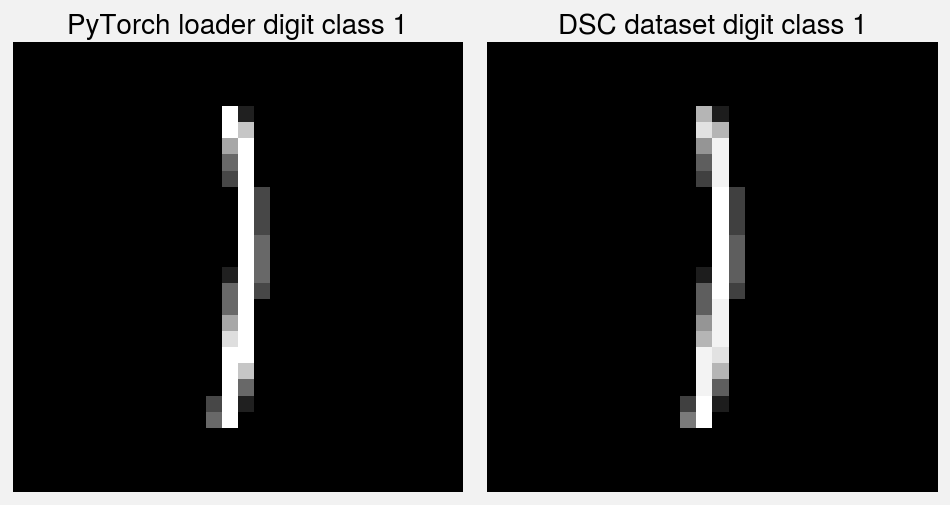

In [7]:
img_idx = rand_state.randint(batch_size)
fig, axs = plot.subplots(ncols=2)
axs[0].imshow(image_batch.numpy()[img_idx,...].reshape(28, 28), cmap='grays_r')
axs[0].format(title=f'PyTorch loader digit class {label_batch[img_idx]}')
axs[1].imshow(dsc_image_batch[img_idx,...].reshape(28, 28), cmap='grays_r')
axs[1].format(title=f'DSC dataset digit class {tfdp.one_hot_to_dense(dsc_label_batch)[img_idx]}')
pf.clear_axes(axs)
plot.show()

In [8]:
test_image = image_batch[2, ...][None, :]
dsc_forward = [np.squeeze(analyzer.compute_activations(test_image,
    activation_operation=analyzer.model.get_logits))
    for analyzer in analyzers]
fb_forward = [fmodel(test_image.to(device)).cpu().numpy() for fmodel in fmodels]

INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/dpaiton/Work/Projects/mlp_lca_768_latent_75_steps_mnist/checkpoints/mlp_lca_768_latent_75_steps_mnist_v0.0-100000
INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/dpaiton/Work/Projects/slp_lca_768_latent_75_steps_mnist/checkpoints/slp_lca_768_latent_75_steps_mnist_v0.0-100000


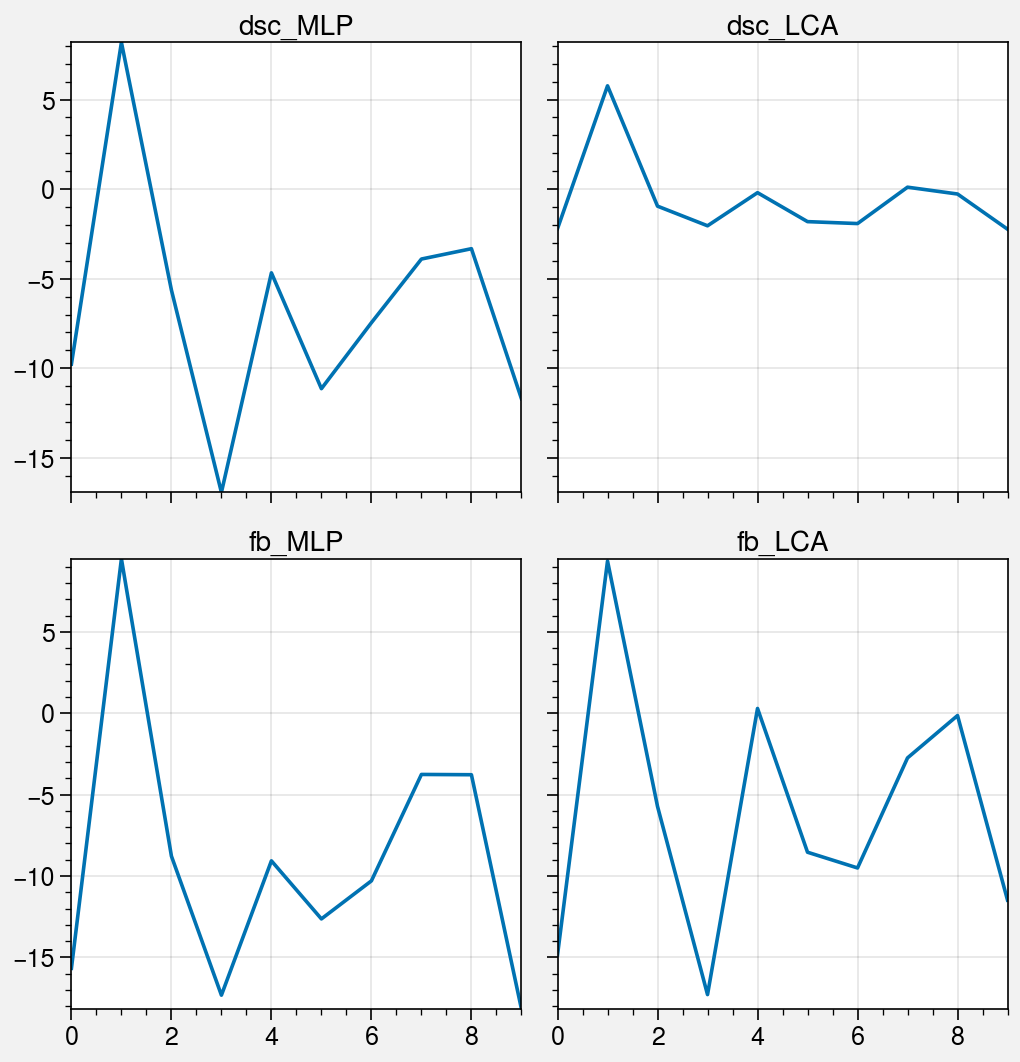

In [9]:
fig, axs = plot.subplots(ncols=2, nrows=2)
axs[0,0].plot(np.squeeze(dsc_forward[0]))
axs[0,0].format(title=f'dsc_{analyzers[0].model_type}')
axs[0,1].plot(np.squeeze(dsc_forward[1]))
axs[0,1].format(title=f'dsc_{analyzers[1].model_type}')
axs[1,0].plot(np.squeeze(fb_forward[0]))
axs[1,0].format(title=f'fb_{fmodels[0].type}')
axs[1,1].plot(np.squeeze(fb_forward[1]))
axs[1,1].format(title=f'fb_{fmodels[1].type}')
plot.show()

In [10]:
for analyzer in analyzers:
    analyzer.class_adversary_analysis(dsc_image_batch,
        dsc_label_batch,
        batch_size=analyzer.analysis_params.eval_batch_size,
        input_id=analyzer.analysis_params.adversarial_input_id,
        target_method = analyzer.analysis_params.adversarial_target_method,
        target_labels = analyzer.analysis_params.adversarial_target_labels,
        save_info=analyzer.analysis_params.save_info)

INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/dpaiton/Work/Projects/mlp_lca_768_latent_75_steps_mnist/checkpoints/mlp_lca_768_latent_75_steps_mnist_v0.0-100000
INFO:tensorflow:Restoring parameters from /gpfs01/bethge/home/dpaiton/Work/Projects/slp_lca_768_latent_75_steps_mnist/checkpoints/slp_lca_768_latent_75_steps_mnist_v0.0-100000


In [11]:
confidence_threshold = 0.9
data = dsc_image_batch
labels = dsc_label_batch.astype(np.int32)
batch_indices = np.arange(data.shape[0], dtype=np.int32)[:,None]
for analyzer in analyzers:
    store_data = np.zeros_like(data)
    store_time_step = -1*np.ones(data.shape[0], dtype=np.int32)
    store_confidence = np.zeros(data.shape[0], dtype=np.float32)
    all_kept_indices = []
    for adv_step in range(analyzer.analysis_params.adversarial_num_steps):
        adversarial_outputs = analyzer.adversarial_outputs[0, adv_step, ...]
        adversarial_outputs[batch_indices, labels] = 0 # zero confidence at true label
        adversarial_confidence = np.max(adversarial_outputs, axis=1) # highest non-true label confidence
        all_above_thresh = np.nonzero(np.squeeze(adversarial_confidence>confidence_threshold))[0]
        keep_indices = np.array([], dtype=np.int32)
        for adv_index in all_above_thresh:
            if adv_index not in set(all_kept_indices):
                keep_indices = np.append(keep_indices, adv_index)
        all_kept_indices.extend(keep_indices)
        store_data[keep_indices, ...] = analyzer.adversarial_images[0, 0, keep_indices, ...]
        store_time_step[keep_indices] = adv_step
        store_confidence[keep_indices] = adversarial_confidence[keep_indices]
    failed_indices = np.array([val for val in batch_indices if val not in all_kept_indices])
    if len(failed_indices) > 0:
        store_confidence[failed_indices] = adversarial_confidence[failed_indices]
        store_data[failed_indices, ...] = data[failed_indices, ...]
    num_failed = data.shape[0] - len(set(all_kept_indices))
    reduc_dim = tuple(range(1, len(data.shape)))
    msd = np.mean((store_data - data)**2, axis=reduc_dim)
    analyzer.adversarial_images = store_data
    analyzer.adversarial_time_step = store_time_step
    analyzer.adversarial_confidence = store_confidence
    analyzer.confidence_threshold = confidence_threshold
    analyzer.failed_indices = failed_indices
    analyzer.success_indices = list(set(all_kept_indices))
    analyzer.mean_squared_distances = msd
    analyzer.num_failed = num_failed
    print(f'analyzer for model {analyzer.model_type} had {analyzer.num_failed} failed indices')

analyzer for model MLP had 0 failed indices
analyzer for model LCA had 8 failed indices


In [12]:
class LinfProjectedGradientDescentAttackWithStopping(LinfProjectedGradientDescentAttack):
    def __init__(
        self,
        *,
        rel_stepsize: float = 0.025,
        abs_stepsize: Optional[float] = None,
        steps: int = 50,
        random_start: bool = True,
    ):
        super().__init__(
            rel_stepsize=rel_stepsize,
            abs_stepsize=abs_stepsize,
            steps=steps,
            random_start=random_start,
        )
        
    def normalize(
        self, gradients: ep.Tensor, *, x: ep.Tensor, bounds: Bounds
    ) -> ep.Tensor:
        return gradients.sign()
        
    def run(
        self,
        model: Model,
        inputs: T,
        criterion: Union[Misclassification, T],
        *,
        epsilon: float,
        **kwargs: Any,
    ) -> T:
        raise_if_kwargs(kwargs)
        x0, restore_type = ep.astensor_(inputs)
        criterion_ = get_criterion(criterion)
        del inputs, criterion, kwargs

        if not isinstance(criterion_, Misclassification):
            raise ValueError("unsupported criterion")

        labels = criterion_.labels
        loss_fn = self.get_loss_fn(model, labels)

        if self.abs_stepsize is None:
            stepsize = self.rel_stepsize * epsilon
        else:
            stepsize = self.abs_stepsize

        x = x0

        if self.random_start:
            x = self.get_random_start(x0, epsilon)
            x = ep.clip(x, *model.bounds)
        else:
            x = x0
        confidence_threshold = 0.7#0.9
        store_x = np.zeros_like(x)
        store_time_step = -1*np.ones(x.shape[0], dtype=np.int32)
        store_confidence = np.zeros(x.shape[0], dtype=np.float32)
        all_kept_indices = []
        time_step = 0
        num_failed = 0
        while len(set(all_kept_indices)) < x.shape[0]:
            loss, gradients = self.value_and_grad(loss_fn, x)
            gradients = self.normalize(gradients=gradients, x=x, bounds=model.bounds)
            x = x + stepsize * gradients
            x = self.project(x, x0, epsilon)
            x = ep.clip(x, *model.bounds)
            
            # for untargeted attacks
            adversarial_outputs = ep.softmax(model(x)).numpy().copy()
            adversarial_outputs[np.arange(x.shape[0]), labels.numpy()] = 0 # zero confidence at true label
            adversarial_confidence = ep.max(adversarial_outputs, axis=1) # highest non-true label confidence
            
            all_above_thresh = np.nonzero(np.squeeze(adversarial_confidence>confidence_threshold))[0]
            keep_indices = np.array([], dtype=np.int32)
            for adv_index in all_above_thresh:
                if adv_index not in set(all_kept_indices):
                    keep_indices = np.append(keep_indices, adv_index)
            all_kept_indices.extend(keep_indices)
            store_x[keep_indices, ...] = x.numpy()[keep_indices, ...]
            store_time_step[keep_indices] = time_step
            store_confidence[keep_indices] = adversarial_confidence[keep_indices]
            time_step += 1
            if time_step == self.steps-1:
                num_failed = x.shape[0] - len(set(all_kept_indices))
                print(f'Max steps = {self.steps} reached for model {model.type}, {num_failed} images did not achieve adversarial confidence threshold of {confidence_threshold}')
                #import IPython; IPython.embed(); raise SystemExit
                break
        failed_indices = np.array([val for val in np.arange(x.shape[0], dtype=np.int32) if val not in all_kept_indices])
        if len(failed_indices) > 0:
            store_confidence[failed_indices] = adversarial_confidence[failed_indices]
            store_x[failed_indices, ...] = x[failed_indices, ...]
        reduc_dim = tuple(range(1, len(x.shape)))
        msd = np.mean(np.square(store_x - x0.numpy()), axis=reduc_dim)
        model.adversarial_images.append(store_x)
        model.adversarial_time_step.append(store_time_step)
        model.adversarial_confidence.append(store_confidence)
        model.confidence_threshold.append(confidence_threshold)
        model.success_indices.append(np.array(all_kept_indices, dtype=np.int32))
        model.failed_indices.append(failed_indices)
        model.mean_squared_distances.append(msd)
        model.num_failed.append(num_failed)
        return restore_type(x)

In [13]:
load_results = False

attack_params = {
    'LinfPGD': {
        'random_start':False,
        'abs_stepsize':analysis_params.adversarial_step_size,
        'steps':analysis_params.adversarial_num_steps # maximum number of steps
    }
}
epsilons = [1.0]
attack = LinfProjectedGradientDescentAttackWithStopping(**attack_params['LinfPGD'])

num_batches = 1
batch_size = test_loader.batch_size
num_images = batch_size
for fmodel in fmodels:
    fmodel.adversarial_images = []
    fmodel.adversarial_time_step = []
    fmodel.adversarial_confidence = []
    fmodel.confidence_threshold = []
    fmodel.failed_indices = []
    fmodel.mean_squared_distances = []
    fmodel.num_failed = []
    fmodel.success_indices = []
    advs, _, success = attack(fmodel, image_batch.to(device), label_batch.to(device), epsilons=epsilons)
    fmodel.success = success.type(torch.float32)
    print(f'model {fmodel.type} had {fmodel.num_failed[0]} failed indices')

model MLP had 0 failed indices
model LCA had 0 failed indices


In [14]:
print(f'DSC {analyzers[0].model_type} clean accuracy = {analyzers[0].adversarial_clean_accuracy} and adv accuracy = {analyzers[0].adversarial_adv_accuracy}')

print(f'DSC {analyzers[1].model_type} clean accuracy = {analyzers[1].adversarial_clean_accuracy} and adv accuracy = {analyzers[1].adversarial_adv_accuracy}')

print(f'FB {fmodels[0].type} clean accuracy = {accuracy(fmodels[0], image_batch.to(device), label_batch.to(device))} and adv accuracy = {1.0 - fmodels[0].success.mean(axis=-1).cpu().numpy().round(2)}')

print(f'FB {fmodels[1].type} clean accuracy = {accuracy(fmodels[1], image_batch.to(device), label_batch.to(device))} and adv accuracy = {1.0 - fmodels[1].success.mean(axis=-1).cpu().numpy().round(2)}')

DSC MLP clean accuracy = [0.98] and adv accuracy = [0.16]
DSC LCA clean accuracy = [0.98] and adv accuracy = [0.16]
FB MLP clean accuracy = 1.0 and adv accuracy = [0.]
FB LCA clean accuracy = 1.0 and adv accuracy = [0.]


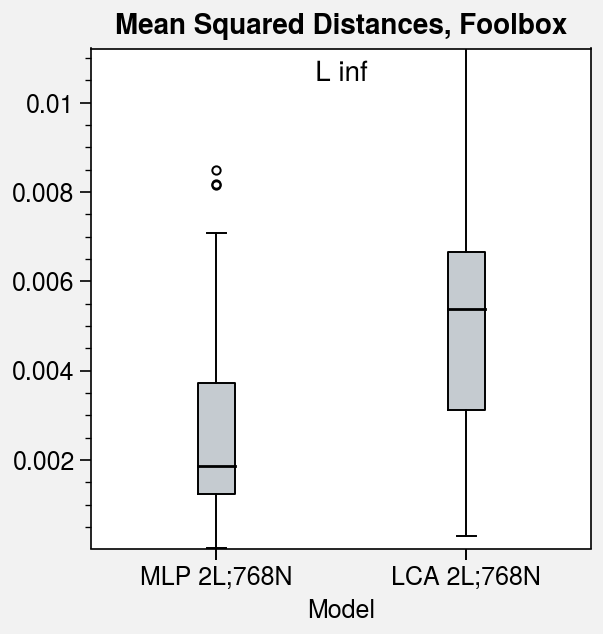

In [15]:
all_success_indices = np.union1d(fmodels[0].success_indices[0], fmodels[1].success_indices[0])
adv_results_list = [np.array(fmodel.mean_squared_distances[0])[all_success_indices] for fmodel in fmodels]
all_results = np.stack(adv_results_list, axis=-1).squeeze()
names = ['MLP 2L;768N','LCA 2L;768N']

data = pd.DataFrame(
    all_results,
    columns=pd.Index(names, name='Model')
)
fig, axs = plot.subplots(ncols=1, axwidth=2.5)
axs.format(grid=False, suptitle='Mean Squared Distances, Foolbox')
ax = axs[0]
obj1 = ax.boxplot(
    data, linewidth=0.7, marker='.', fillcolor='gray5',
    medianlw=1, mediancolor='k', meancolor='k', meanlw=1
)
ax.format(title='L inf', titleloc='uc')

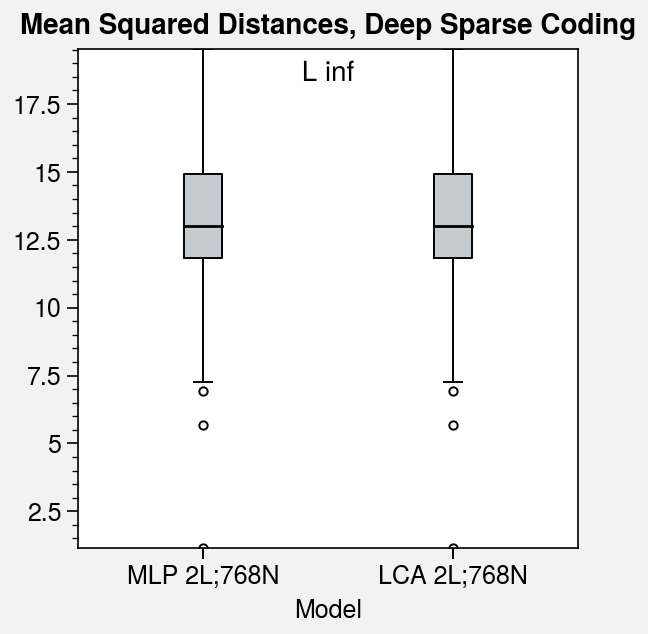

In [16]:
all_success_indices = np.intersect1d(analyzers[0].success_indices, analyzers[1].success_indices)
adv_results_list = [analyzer.mean_squared_distances[all_success_indices] for analyzer in analyzers]
all_results = np.stack(adv_results_list, axis=-1).squeeze()
names = ['MLP 2L;768N','LCA 2L;768N']

data = pd.DataFrame(
    all_results,
    columns=pd.Index(names, name='Model')
)
fig, axs = plot.subplots(ncols=1, axwidth=2.5)
axs.format(grid=False, suptitle='Mean Squared Distances, Deep Sparse Coding')
ax = axs[0]
obj1 = ax.boxplot(
    data, linewidth=0.7, marker='.', fillcolor='gray5',
    medianlw=1, mediancolor='k', meancolor='k', meanlw=1
)
ax.format(title='L inf', titleloc='uc')